In [2]:
# 导库环节
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, warnings
from tqdm import tqdm
import librosa
from joblib import Parallel, delayed
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
print("Libraries imported successfully.")


Libraries imported successfully.


In [4]:
# 数据路径设置
data_path = '/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800'

# 检查数据路径是否存在
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No: {data_path}")

# 加载所有WAV文件
files = glob.glob(os.path.join(data_path, '*.wav'))
print(f'Total files: {len(files)}')
print(f'Data path exists and files loaded successfully.')


Total files: 800
Data path exists and files loaded successfully.


In [5]:
data = []
for f in files:
    name = f.split('/')[-1]
    parts = name.split('_')
    song = parts[3].split('.')[0]
    data.append([name, parts[0], parts[1], parts[2], song, f])  # 添加完整路径
df = pd.DataFrame(data, columns=['file', 'participant', 'type', 'number', 'song', 'path']).set_index('file')

print("数据集统计:")
print(f"总样本数: {len(df)}")
print(f"\n每首歌的样本数:")
print(df['song'].value_counts())
print(f"\nHum vs Whistle:")
print(df['type'].value_counts())
print(f"\n参与者数量: {df['participant'].nunique()}")


数据集统计:
总样本数: 800

每首歌的样本数:
song
Married          100
Necessities      100
RememberMe       100
Feeling          100
Friend           100
Happy            100
TryEverything    100
NewYork          100
Name: count, dtype: int64

Hum vs Whistle:
type
hum        487
whistle    313
Name: count, dtype: int64

参与者数量: 120


In [8]:
# Cell 4: 增强版特征提取（修复并行崩溃问题）
def get_pitch(x, fs):
    f0, _, _ = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs)
    return f0

def extract_features_enhanced(file_path, df):
    """提取增强特征（去掉导致崩溃的tempo特征）"""
    try:
        name = file_path.split('/')[-1]
        song = df.loc[name]['song']
        participant = df.loc[name]['participant']
        audio_type = df.loc[name]['type']
        
        # 加载音频
        x, fs = librosa.load(file_path, sr=None)
        
        # 基础特征
        f0 = get_pitch(x, fs)
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if not np.all(np.isnan(f0)) else 0
        pitch_std = np.nanstd(f0) if not np.all(np.isnan(f0)) else 0
        pitch_min = np.nanmin(f0) if not np.all(np.isnan(f0)) else 0
        pitch_max = np.nanmax(f0) if not np.all(np.isnan(f0)) else 0
        voiced_fr = np.sum(~np.isnan(f0))/len(f0)
        
        # 新增特征
        # 1. MFCC特征（前13个系数的均值和标准差）
        mfcc = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # 2. 色度特征
        chroma = librosa.feature.chroma_stft(y=x, sr=fs)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)
        
        # 3. 谱对比度
        contrast = librosa.feature.spectral_contrast(y=x, sr=fs)
        contrast_mean = np.mean(contrast, axis=1)
        
        # 4. 过零率
        zcr = librosa.feature.zero_crossing_rate(x)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # 5. 谱质心
        spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=fs)
        spectral_centroid_mean = np.mean(spectral_centroids)
        spectral_centroid_std = np.std(spectral_centroids)
        
        # 6. 谱带宽
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=x, sr=fs)
        spectral_bandwidth_mean = np.mean(spectral_bandwidth)
        
        # 7. 谱滚降
        spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
        spectral_rolloff_mean = np.mean(spectral_rolloff)
        
        # 组合所有特征
        features = [
            power, pitch_mean, pitch_std, pitch_min, pitch_max, voiced_fr,
            zcr_mean, zcr_std, 
            spectral_centroid_mean, spectral_centroid_std,
            spectral_bandwidth_mean, spectral_rolloff_mean,
            *contrast_mean,
            *mfcc_mean, *mfcc_std, 
            *chroma_mean, *chroma_std
        ]
        
        return features, song, participant, audio_type
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None, None

print("开始提取增强特征（包含MFCC、Chroma、谱特征等）...")
print("注意：已移除tempo特征以避免多进程崩溃问题\n")

# 使用threading backend避免numba的多进程问题
results = Parallel(n_jobs=-1, backend='threading', verbose=10)(
    delayed(extract_features_enhanced)(row['path'], df) for idx, row in df.iterrows()
)

# 整理结果
X, y, participants, audio_types = [], [], [], []
for features, label, participant, audio_type in results:
    if features is not None:
        X.append(features)
        y.append(label)
        participants.append(participant)
        audio_types.append(audio_type)

X = np.array(X)
y = np.array(y)
participants = np.array(participants)
audio_types = np.array(audio_types)

print(f"\n特征提取完成！")
print(f"特征矩阵形状: X={X.shape}")
print(f"标签形状: y={y.shape}")
print(f"特征数量: {X.shape[1]}")


开始提取增强特征（包含MFCC、Chroma、谱特征等）...
注意：已移除tempo特征以避免多进程崩溃问题



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 214 tasks      | elaps


特征提取完成！
特征矩阵形状: X=(800, 69)
标签形状: y=(800,)
特征数量: 69


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 21.1min finished


In [9]:
#数据分割，整理数据集
# 编码标签
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 按参与者分组，避免同一参与者同时出现在训练集和测试集
unique_participants = np.unique(participants)
train_participants, test_participants = train_test_split(
    unique_participants, test_size=0.2, random_state=42
)

# 创建训练集和测试集的mask
train_mask = np.isin(participants, train_participants)
test_mask = np.isin(participants, test_participants)

X_train_full = X[train_mask]
y_train_full = y_encoded[train_mask]
X_test = X[test_mask]
y_test = y_encoded[test_mask]

# 从训练集中再分出验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"数据分割完成（按参与者分组）:")
print(f"训练集: {X_train.shape[0]} 样本")
print(f"验证集: {X_val.shape[0]} 样本")
print(f"测试集: {X_test.shape[0]} 样本")
print(f"\n训练集参与者: {len(train_participants)}")
print(f"测试集参与者: {len(test_participants)}")

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


数据分割完成（按参与者分组）:
训练集: 513 样本
验证集: 129 样本
测试集: 158 样本

训练集参与者: 96
测试集参与者: 24


In [10]:
# 定义多个baseline模型
models = {
    'SVM-RBF': SVC(kernel='rbf', random_state=42),
    'SVM-Linear': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 训练并评估每个模型
results = {}
print("开始训练Baseline模型...\n")
for name, model in models.items():
    print(f"训练 {name}...")
    model.fit(X_train_scaled, y_train)
    
    # 验证集评估
    y_val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # 测试集评估
    y_test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    results[name] = {
        'model': model,
        'val_acc': val_acc,
        'val_f1': val_f1,
        'test_acc': test_acc,
        'test_f1': test_f1
    }
    
    print(f"  验证集准确率: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"  测试集准确率: {test_acc:.4f}, F1: {test_f1:.4f}\n")

# 结果可视化
results_df = pd.DataFrame({
    name: {'Validation Acc': res['val_acc'], 
           'Validation F1': res['val_f1'],
           'Test Acc': res['test_acc'],
           'Test F1': res['test_f1']}
    for name, res in results.items()
}).T

print("\n模型对比结果:")
print(results_df.round(4))

# 找出最佳模型
best_model_name = results_df['Test Acc'].idxmax()
print(f"\n最佳模型: {best_model_name} (测试准确率: {results_df.loc[best_model_name, 'Test Acc']:.4f})")


开始训练Baseline模型...

训练 SVM-RBF...
  验证集准确率: 0.2713, F1: 0.2650
  测试集准确率: 0.2658, F1: 0.2765

训练 SVM-Linear...
  验证集准确率: 0.2946, F1: 0.2902
  测试集准确率: 0.2595, F1: 0.2606

训练 Random Forest...
  验证集准确率: 0.2636, F1: 0.2430
  测试集准确率: 0.3038, F1: 0.3055

训练 KNN...
  验证集准确率: 0.1550, F1: 0.1590
  测试集准确率: 0.2215, F1: 0.2232

训练 Gradient Boosting...
  验证集准确率: 0.2791, F1: 0.2794
  测试集准确率: 0.2658, F1: 0.2707

训练 MLP...
  验证集准确率: 0.2403, F1: 0.2364
  测试集准确率: 0.2911, F1: 0.2937


模型对比结果:
                   Validation Acc  Validation F1  Test Acc  Test F1
SVM-RBF                    0.2713         0.2650    0.2658   0.2765
SVM-Linear                 0.2946         0.2902    0.2595   0.2606
Random Forest              0.2636         0.2430    0.3038   0.3055
KNN                        0.1550         0.1590    0.2215   0.2232
Gradient Boosting          0.2791         0.2794    0.2658   0.2707
MLP                        0.2403         0.2364    0.2911   0.2937

最佳模型: Random Forest (测试准确率: 0.3038)


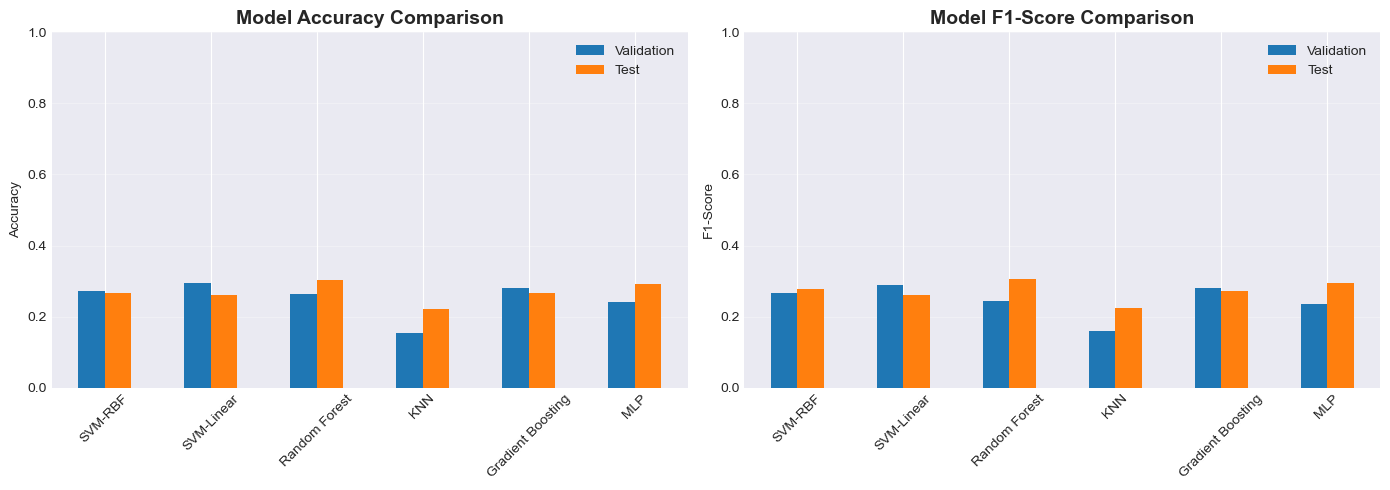

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 准确率对比
results_df[['Validation Acc', 'Test Acc']].plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
axes[0].legend(['Validation', 'Test'])
axes[0].grid(axis='y', alpha=0.3)

# F1分数对比
results_df[['Validation F1', 'Test F1']].plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim(0, 1)
axes[1].legend(['Validation', 'Test'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


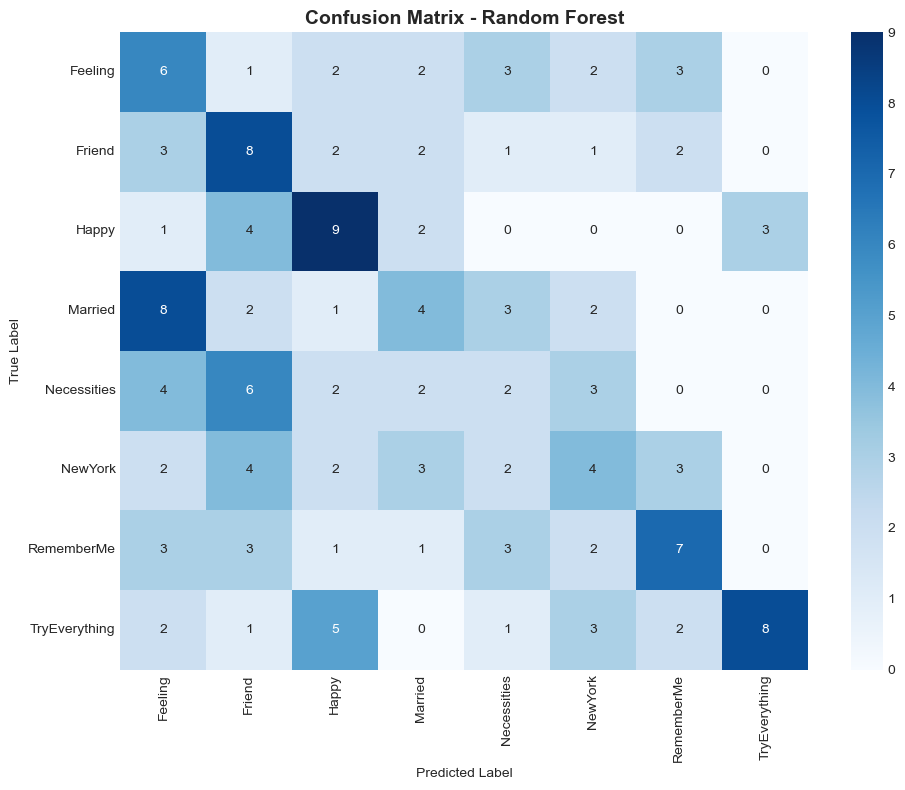


Random Forest 详细分类报告:
               precision    recall  f1-score   support

      Feeling       0.21      0.32      0.25        19
       Friend       0.28      0.42      0.33        19
        Happy       0.38      0.47      0.42        19
      Married       0.25      0.20      0.22        20
  Necessities       0.13      0.11      0.12        19
      NewYork       0.24      0.20      0.22        20
   RememberMe       0.41      0.35      0.38        20
TryEverything       0.73      0.36      0.48        22

     accuracy                           0.30       158
    macro avg       0.33      0.30      0.30       158
 weighted avg       0.33      0.30      0.31       158



In [12]:
best_model = results[best_model_name]['model']
y_test_pred = best_model.predict(X_test_scaled)

# 混淆矩阵
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 详细分类报告
print(f"\n{best_model_name} 详细分类报告:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


In [13]:
# 对最佳模型进行超参数调优
print(f"对 {best_model_name} 进行超参数调优...\n")

if 'SVM' in best_model_name:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    }
elif 'Random Forest' in best_model_name:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
elif 'Gradient Boosting' in best_model_name:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif 'KNN' in best_model_name:
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    }
else:  # MLP
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 75)],
        'alpha': [0.0001, 0.001, 0.01]
    }

# GridSearchCV
grid_search = GridSearchCV(
    models[best_model_name], param_grid, 
    cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)
grid_search.fit(X_train_scaled, y_train)

print(f"\n最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证准确率: {grid_search.best_score_:.4f}")

# 使用最佳参数的模型在测试集上评估
best_tuned_model = grid_search.best_estimator_
y_test_pred_tuned = best_tuned_model.predict(X_test_scaled)
test_acc_tuned = accuracy_score(y_test, y_test_pred_tuned)
test_f1_tuned = f1_score(y_test, y_test_pred_tuned, average='weighted')

print(f"\n调优后测试集准确率: {test_acc_tuned:.4f}")
print(f"调优后测试集F1分数: {test_f1_tuned:.4f}")
print(f"准确率提升: {test_acc_tuned - results[best_model_name]['test_acc']:.4f}")


对 Random Forest 进行超参数调优...

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=